# Projet PCM : DataManagement & Modélisation

<div class="alert-warning">
<font color='black'>
L'intérêt de cet article est de présenter une segmentation de coureurs cyclistes à partir de leurs caractéristiques renseignées dans un jeu vidéo.
<br>
<br>
L'idée consiste alors à importer ces données récupérées au sein de l'éditeur du jeu vidéo, puis à manipuler ces données à travers différentes étapes (statistiques descriptives, indicateurs etc...) en vue d'établir des groupes homogènes de coureurs.
<br>
<br>    
Le résultat attendu consiste en l'obtention de ces groupes homogènes ("segments") partageant les mêmes caractéristiques malgré l'hétérogénéité de ces individus dans le jeu vidéo.
<br>
<br>
De telle sorte à reproduire des segments proches de la réalité concernant la thématique du segments et le réalisme des coureurs composant chacun de ces groupes.
<font color='black'>


## 0. Paramétrage

### 0.1 / Chargements des différents packages

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from datetime import date

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics, neighbors
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, neighbors

from sklearn import preprocessing

In [3]:
#pip install sklearn

### 0.2 / Automatisation des dates

In [4]:
DTJ=date.today()
print(DTJ)

current_year = DTJ.strftime("%Y")
print("Année actuelle =", current_year)

2023-06-29
Année actuelle = 2023


### 0.3 / Chemins de travail

In [5]:
# Connaître l'emplacement de base
os.getcwd()

'C:\\Users\\gaeta\\Documents\\03_ PYTHON\\14_PROJET_PCM\\01_NOTEBOOK'

In [6]:
# Emplacements de travail
path="C:/Users/gaeta/Documents/03_ PYTHON/14_PROJET_PCM/02_INPUTS"
results="C:/Users/gaeta/Documents/03_ PYTHON/14_PROJET_PCM/03_OUTPUTS"
os.chdir(path)
print(path)
print(results)

C:/Users/gaeta/Documents/03_ PYTHON/14_PROJET_PCM/02_INPUTS
C:/Users/gaeta/Documents/03_ PYTHON/14_PROJET_PCM/03_OUTPUTS


## 1. Imports des différents fichiers

### 1.1 / Cyclistes

In [7]:
cyclists=pd.read_excel(path+"/_20230301_inputs_projet_pcm.xlsx",sheet_name="CYCLISTS")
print(cyclists["Date_de_naissance"].dtypes)
cyclists.head()

datetime64[ns]


,IDcyclist,Nom,Prenom,Prenom_nom,ID_team,fklDregion,ID_contrat,fklDNextcontract,gene_sz_photo,Date_de_naissance,...,value_i_yearneopro,gene_i_nb_victory,gene_i_nb_tdf,gene_i_nb_giro,gene_i_nb_vuelta,gene_i_nb_sanremo,gene_i_nb_flandres,gene_i_nb_roubaix,gene_i_nb_liege,gene_i_nb_lombardia
0,2,Zeits,Andrey,Zeits A.,Astana Qazaqstan Team,KAZ,0,0,azeits,1986-12-14,...,2008,1,2,9,8,0,0,0,0,4
1,3,Valverde,Alejandro,Valverde A.,Movistar Team,Region_de_Murcia,0,0,avalverde,1980-04-25,...,2002,130,14,1,15,7,1,0,15,10
2,4,Madouas,Valentin,Madouas V.,Groupama - FDJ,Bretagne,0,0,vmadouas,1996-07-12,...,2017,2,2,1,0,0,2,0,4,1
3,5,Seigle,Romain,Seigle R.,-,Poitou-Charentes,0,0,rseigle,1994-10-11,...,2018,0,0,1,2,0,0,0,4,1
4,16,Mollema,Bauke,Mollema B.,Trek - Segafredo,Groningue,0,0,bmollema,1986-11-26,...,2008,17,11,4,4,1,0,0,8,13


### 1.2 / Teams

In [8]:
teams=pd.read_excel(path+"/_20230301_inputs_projet_pcm.xlsx",sheet_name="TEAMS")
teams.head()

,Idteam,Nom_court,Nom_team,fklDsponsor,gene_b_licensed,ID_country,adresse_mail_equipe,Nom_manageur_general,ID_division
0,1,Movistar,Movistar Team,Movistar,True,ESP,movistar.com,Eusebio Unzue,GS1
1,2,INEOS Grenadiers,INEOS Grenadiers,INEOS Grenadiers,True,GBR,team-ineos.com,Dave Brailsford,GS1
2,3,AG2R Citroën,AG2R Citroën Team,AG2R Citroën,True,FRA,ag2r-citroen.fr,Vincent Lavenu,GS1
3,5,EF-EasyPost,EF Education-EasyPost,EF Education-EasyPost,True,USA,ef-easypost.com,Jonathan Vaughters,GS1
4,6,Groupama - FDJ,Groupama - FDJ,Groupama - FDJ,True,FRA,groupama-fdj.fr,Marc Madiot,GS1


### 1.3 / Référentiel pays

In [9]:
ref_pays=pd.read_excel(path+"/_20230301_referentiel_pays.xlsx",sheet_name="Feuil1")
ref_pays.head()

,Region,Pays
0,KAZ,KAZ
1,Region_de_Murcia,ESP
2,Bretagne,FRA
3,Poitou-Charentes,FRA
4,Groningue,NLD


## 2. DataManagement

### 2.1 / Conservation des colonnes de travail de la table CYCLISTS

In [10]:
cyclists=cyclists[['IDcyclist','Nom','Prenom','ID_team','fklDregion','Date_de_naissance','Popularite','value_f_potentiel','taille_coureur','poids_coureur','carac_plaine','carac_montagne','carac_descente','carac_paves','carac_clm','carac_prologue','carac_sprint','carac_acceleration','carac_endurance','carac_resistance','carac_recuperation','carac_vallon','carac_baroudeur','prendra_sa_retraite','Coureur_champion','gene_ilist_flkDfavorite_races','value_i_yearneopro','gene_i_nb_victory','gene_i_nb_tdf','gene_i_nb_giro','gene_i_nb_vuelta','gene_i_nb_sanremo','gene_i_nb_flandres','gene_i_nb_roubaix','gene_i_nb_liege','gene_i_nb_lombardia']]

# Calcul du niveau moyen par coureur
cyclists["carac_moy"]=round(((cyclists['carac_plaine'] + cyclists['carac_montagne'] + cyclists['carac_descente'] +
cyclists['carac_paves'] + cyclists['carac_clm'] + cyclists['carac_prologue'] + cyclists['carac_sprint'] +
cyclists['carac_acceleration'] + cyclists['carac_endurance'] + cyclists['carac_resistance'] + 
cyclists['carac_recuperation'] + cyclists['carac_vallon'] + cyclists['carac_baroudeur'])/(13)),2)
cyclists.head()

,IDcyclist,Nom,Prenom,ID_team,fklDregion,Date_de_naissance,Popularite,value_f_potentiel,taille_coureur,poids_coureur,...,gene_i_nb_victory,gene_i_nb_tdf,gene_i_nb_giro,gene_i_nb_vuelta,gene_i_nb_sanremo,gene_i_nb_flandres,gene_i_nb_roubaix,gene_i_nb_liege,gene_i_nb_lombardia,carac_moy
0,2,Zeits,Andrey,Astana Qazaqstan Team,KAZ,1986-12-14,17.0,3.5,177,69,...,1,2,9,8,0,0,0,0,4,66.38
1,3,Valverde,Alejandro,Movistar Team,Region_de_Murcia,1980-04-25,83.0,5.5,177,61,...,130,14,1,15,7,1,0,15,10,73.08
2,4,Madouas,Valentin,Groupama - FDJ,Bretagne,1996-07-12,0.0,5.5,178,71,...,2,2,1,0,0,2,0,4,1,72.38
3,5,Seigle,Romain,-,Poitou-Charentes,1994-10-11,0.0,4.0,169,63,...,0,0,1,2,0,0,0,4,1,65.54
4,16,Mollema,Bauke,Trek - Segafredo,Groningue,1986-11-26,63.0,5.5,184,66,...,17,11,4,4,1,0,0,8,13,73.69


### 2.2 / Premiers éléments stylisés

In [11]:
list_col_cyclists=list(cyclists.columns)
print(list_col_cyclists)
print("\n")
print(cyclists.shape)
print("\n")
print("La première colonne du dataframe est : " + list_col_cyclists[0])
print("\n")
print(str(cyclists["prendra_sa_retraite"].sum()) + " cyclistes prendront leur retraite à la fin de la saison")     # 3
print((~cyclists["prendra_sa_retraite"]).sum())  # 2

['IDcyclist', 'Nom', 'Prenom', 'ID_team', 'fklDregion', 'Date_de_naissance', 'Popularite', 'value_f_potentiel', 'taille_coureur', 'poids_coureur', 'carac_plaine', 'carac_montagne', 'carac_descente', 'carac_paves', 'carac_clm', 'carac_prologue', 'carac_sprint', 'carac_acceleration', 'carac_endurance', 'carac_resistance', 'carac_recuperation', 'carac_vallon', 'carac_baroudeur', 'prendra_sa_retraite', 'Coureur_champion', 'gene_ilist_flkDfavorite_races', 'value_i_yearneopro', 'gene_i_nb_victory', 'gene_i_nb_tdf', 'gene_i_nb_giro', 'gene_i_nb_vuelta', 'gene_i_nb_sanremo', 'gene_i_nb_flandres', 'gene_i_nb_roubaix', 'gene_i_nb_liege', 'gene_i_nb_lombardia', 'carac_moy']


(2212, 37)


La première colonne du dataframe est : IDcyclist


7 cyclistes prendront leur retraite à la fin de la saison
2205


### Informations concernant les équipes et régions des coureurs

In [12]:
print(list(cyclists["ID_team"].unique()))
print("\n")
print("On comptabilise " + str(len(list(cyclists["ID_team"].unique()))) + " équipes distinctes")
print("\n")
print("\n")
print(list(cyclists["fklDregion"].unique()))
print("\n")
print("On comptabilise " + str(len(list(cyclists["fklDregion"].unique()))) + " régions distinctes")

['Astana Qazaqstan Team', 'Movistar Team', 'Groupama - FDJ', '-', 'Trek - Segafredo', 'Team Jumbo - Visma', 'EF Education-EasyPost', 'Israël - Premier Tech', 'Lotto Soudal', 'Bahrain Victorious', 'Intermarché-Wanty-Gobert Matériaux', 'AG2R Citroën Team', 'Burgos HD', 'Team TotalEnergies', 'Cycling Club Tavira', 'B&B HOTELS KTM', 'Euskaltel - Euskadi', 'Quick-Step - Alpha Vinyl', 'INEOS Grenadiers', 'Team Arkéa - Samsic', 'Andrina Giacomoli - Sadermac', 'Cofidis', 'Team BikeExchange - Jayco', 'UAE Team Emirates', 'Caja Rural - Seguros RGA', 'V25 - Porto', 'Eolo-Kometa Cycling Team', 'Team DSM', 'Radio Papa - Bavisto', 'Vismer ETS Team', 'Bardiani CSF Faizanè', 'St Michel - Auber 93', 'Human Powered Health', 'Alpecin-Deceuninck', 'Elkov - Kasper', 'BORA - hansgrohe', 'Go Sport - Roubaix Lille Métropole', 'Team Okyo', 'Mitoc - Solwatt', 'Beat Cycling', 'Team Nova Sudisk', 'Team Gourmetfestin - Simple', 'Team Volvaberg Qantic', 'Erappel', 'Bingoal - Pauwels Sauces - WB', 'Uno-X Pro Cycling

### 2.3 / Manipulations des champs date

In [13]:
cyclists["Age"] =(round((datetime.now() - cyclists["Date_de_naissance"]) / np.timedelta64(1, 'Y'),2)).astype(int)
cyclists["Annees_exp"]=int(current_year)-cyclists["value_i_yearneopro"]
cyclists.head()

,IDcyclist,Nom,Prenom,ID_team,fklDregion,Date_de_naissance,Popularite,value_f_potentiel,taille_coureur,poids_coureur,...,gene_i_nb_giro,gene_i_nb_vuelta,gene_i_nb_sanremo,gene_i_nb_flandres,gene_i_nb_roubaix,gene_i_nb_liege,gene_i_nb_lombardia,carac_moy,Age,Annees_exp
0,2,Zeits,Andrey,Astana Qazaqstan Team,KAZ,1986-12-14,17.0,3.5,177,69,...,9,8,0,0,0,0,4,66.38,36,15
1,3,Valverde,Alejandro,Movistar Team,Region_de_Murcia,1980-04-25,83.0,5.5,177,61,...,1,15,7,1,0,15,10,73.08,43,21
2,4,Madouas,Valentin,Groupama - FDJ,Bretagne,1996-07-12,0.0,5.5,178,71,...,1,0,0,2,0,4,1,72.38,26,6
3,5,Seigle,Romain,-,Poitou-Charentes,1994-10-11,0.0,4.0,169,63,...,1,2,0,0,0,4,1,65.54,28,5
4,16,Mollema,Bauke,Trek - Segafredo,Groningue,1986-11-26,63.0,5.5,184,66,...,4,4,1,0,0,8,13,73.69,36,15


### 2.4 / Caractéristiques des coureurs

#### Liste des colonnes "caractéristiques"

In [14]:
liste_col_caract=['carac_plaine', 'carac_montagne', 'carac_descente', 'carac_paves', 'carac_clm', 'carac_prologue', 'carac_sprint', 'carac_acceleration', 'carac_endurance', 'carac_resistance', 'carac_recuperation', 'carac_vallon', 'carac_baroudeur']
liste_col_caract

['carac_plaine',
 'carac_montagne',
 'carac_descente',
 'carac_paves',
 'carac_clm',
 'carac_prologue',
 'carac_sprint',
 'carac_acceleration',
 'carac_endurance',
 'carac_resistance',
 'carac_recuperation',
 'carac_vallon',
 'carac_baroudeur']

#### Min et max de ces colonnes

In [15]:
for i in range(len(liste_col_caract)):
    print("Caractéristique min/max en " 
          + str(liste_col_caract[i][6:]) + " : " 
          + str(cyclists[liste_col_caract[i]].min()) + "(min) "
          + str(cyclists[liste_col_caract[i]].max()) + "(max)"
         )


Caractéristique min/max en plaine : 52(min) 83(max)
Caractéristique min/max en montagne : 50(min) 83(max)
Caractéristique min/max en descente : 51(min) 85(max)
Caractéristique min/max en paves : 50(min) 82(max)
Caractéristique min/max en clm : 52(min) 82(max)
Caractéristique min/max en prologue : 52(min) 83(max)
Caractéristique min/max en sprint : 50(min) 83(max)
Caractéristique min/max en acceleration : 51(min) 84(max)
Caractéristique min/max en endurance : 52(min) 81(max)
Caractéristique min/max en resistance : 51(min) 83(max)
Caractéristique min/max en recuperation : 52(min) 82(max)
Caractéristique min/max en vallon : 52(min) 82(max)
Caractéristique min/max en baroudeur : 54(min) 84(max)


#### Récupération de la division dans laquelle est engagé le coureur + nationalité

In [16]:
cyclists=pd.merge(cyclists, teams, how='left', left_on=['ID_team'], right_on=['Nom_team'])
cyclists=pd.merge(cyclists, ref_pays, how='left', left_on=['fklDregion'], right_on=['Region'])
cyclists.head()

,IDcyclist,Nom,Prenom,ID_team,fklDregion,Date_de_naissance,Popularite,value_f_potentiel,taille_coureur,poids_coureur,...,Nom_court,Nom_team,fklDsponsor,gene_b_licensed,ID_country,adresse_mail_equipe,Nom_manageur_general,ID_division,Region,Pays
0,2,Zeits,Andrey,Astana Qazaqstan Team,KAZ,1986-12-14,17.0,3.5,177,69,...,Astana Qazaqstan,Astana Qazaqstan Team,Astana Qazaqstan,True,KAZ,astana-qazaqstan-team.com,Alexander Vinokourov,GS1,KAZ,KAZ
1,3,Valverde,Alejandro,Movistar Team,Region_de_Murcia,1980-04-25,83.0,5.5,177,61,...,Movistar,Movistar Team,Movistar,True,ESP,movistar.com,Eusebio Unzue,GS1,Region_de_Murcia,ESP
2,4,Madouas,Valentin,Groupama - FDJ,Bretagne,1996-07-12,0.0,5.5,178,71,...,Groupama - FDJ,Groupama - FDJ,Groupama - FDJ,True,FRA,groupama-fdj.fr,Marc Madiot,GS1,Bretagne,FRA
3,5,Seigle,Romain,-,Poitou-Charentes,1994-10-11,0.0,4.0,169,63,...,-,-,0,True,ESP,cyanide.com,-,Free,Poitou-Charentes,FRA
4,16,Mollema,Bauke,Trek - Segafredo,Groningue,1986-11-26,63.0,5.5,184,66,...,Trek - Segafredo,Trek - Segafredo,Trek - Segafredo,True,USA,trek-segafredo.com,Luca Guercilena,GS1,Groningue,NLD


In [17]:
# Répartition des coureurs par division
cyclists["ID_division"].value_counts()

ID_division
Free       689
GS1        535
GS3        454
GS2        373
Under23    161
Name: count, dtype: int64

## 3. Modélisations

Conservation des champs souhaités pour l'analyse

In [18]:
cyclists_seg=cyclists[['IDcyclist', 'Nom', 'Prenom', 'ID_team', 
 'value_f_potentiel',
 'carac_moy', 'carac_plaine', 'carac_montagne', 'carac_descente', 'carac_paves', 'carac_clm',
 'carac_prologue', 'carac_sprint', 'carac_acceleration', 'carac_endurance',
 'carac_resistance', 'carac_recuperation', 'carac_vallon', 'carac_baroudeur',
 'gene_i_nb_victory', 'gene_i_nb_tdf', 'gene_i_nb_giro', 'ID_division']]

cyclists_seg=cyclists_seg.loc[(cyclists_seg['ID_division'] == "GS1") | (cyclists_seg['ID_division'] == "GS2" )]
cyclists_seg=cyclists_seg.reset_index()
print(cyclists_seg.shape)
cyclists_seg.head()

(908, 24)


,index,IDcyclist,Nom,Prenom,ID_team,value_f_potentiel,carac_moy,carac_plaine,carac_montagne,carac_descente,...,carac_acceleration,carac_endurance,carac_resistance,carac_recuperation,carac_vallon,carac_baroudeur,gene_i_nb_victory,gene_i_nb_tdf,gene_i_nb_giro,ID_division
0,0,2,Zeits,Andrey,Astana Qazaqstan Team,3.5,66.38,69,73,66,...,65,66,66,71,73,72,1,2,9,GS1
1,1,3,Valverde,Alejandro,Movistar Team,5.5,73.08,70,77,75,...,72,75,76,73,81,70,130,14,1,GS1
2,2,4,Madouas,Valentin,Groupama - FDJ,5.5,72.38,74,75,74,...,70,75,77,70,78,73,2,2,1,GS1
3,4,16,Mollema,Bauke,Trek - Segafredo,5.5,73.69,73,75,67,...,73,77,74,73,78,79,17,11,4,GS1
4,5,17,Van Emden,Jos,Team Jumbo - Visma,4.0,69.15,76,58,70,...,66,67,69,69,68,69,13,2,10,GS1


In [19]:
matrice_seg=cyclists[[ 'carac_montagne', 'carac_sprint', 'carac_paves', 'carac_clm', 'value_f_potentiel', 'carac_recuperation', 'carac_resistance', 'ID_division']]

matrice_seg=matrice_seg.loc[(matrice_seg['ID_division'] == "GS1") | (matrice_seg['ID_division'] == "GS2" )]
matrice_seg=pd.DataFrame(matrice_seg.drop(['ID_division'],axis=1))
matrice_seg=matrice_seg.reset_index()
matrice_seg=pd.DataFrame(matrice_seg.drop(['index'],axis=1))

print(matrice_seg.shape)
matrice_seg.head()

(908, 7)


,carac_montagne,carac_sprint,carac_paves,carac_clm,value_f_potentiel,carac_recuperation,carac_resistance
0,73,61,57,61,3.5,71,66
1,77,67,69,72,5.5,73,76
2,75,64,76,67,5.5,70,77
3,75,68,70,76,5.5,73,74
4,58,64,72,74,4.0,69,69


In [55]:
liste_col_input=list(matrice_seg.columns)
print(liste_col_input)
print("\n",matrice_seg.shape)
print("\n")
print("On utilise " + str(matrice_seg.shape[1]) + " indicateurs lors de la modélisation.")

['carac_montagne', 'carac_sprint', 'carac_paves', 'carac_clm', 'value_f_potentiel', 'carac_recuperation', 'carac_resistance']

 (908, 7)


On utilise 7 indicateurs lors de la modélisation.


In [22]:
matrice_seg_N = pd.DataFrame(columns=["vide"],index=range(0, matrice_seg.shape[0]))

transformer = dict()
X_transformed = dict()

for i in range(0,len(liste_col_input)):
    transformer[i] = preprocessing.MinMaxScaler().fit(matrice_seg[[liste_col_input[i]]])
    X_transformed[i] = transformer[i].transform(matrice_seg[[liste_col_input[i]]])
    

    df = pd.DataFrame(X_transformed[i], columns = [liste_col_input[i]])


    matrice_seg_N = pd.merge(matrice_seg_N,df,left_index=True, right_index=True,how="left")
    matrice_seg_N = matrice_seg_N.select_dtypes(include=[np.float64])

matrice_seg_N

,carac_montagne,carac_sprint,carac_paves,carac_clm,value_f_potentiel,carac_recuperation,carac_resistance
0,0.666667,0.31250,0.137931,0.275862,0.5,0.620690,0.433333
1,0.800000,0.50000,0.551724,0.655172,0.9,0.689655,0.766667
2,0.733333,0.40625,0.793103,0.482759,0.9,0.586207,0.800000
3,0.733333,0.53125,0.586207,0.793103,0.9,0.689655,0.700000
4,0.166667,0.40625,0.655172,0.724138,0.6,0.551724,0.533333
...,...,...,...,...,...,...,...
903,0.100000,0.15625,0.310345,0.379310,0.2,0.344828,0.266667
904,0.400000,0.50000,0.448276,0.379310,0.5,0.241379,0.366667
905,0.066667,0.15625,0.206897,0.344828,0.0,0.241379,0.200000
906,0.066667,0.37500,0.413793,0.172414,0.2,0.172414,0.133333


### 4 / Statistiques descriptives

#### 4.1 / Etude des corrélations

In [23]:
matrice_seg.corr()

,carac_montagne,carac_sprint,carac_paves,carac_clm,value_f_potentiel,carac_recuperation,carac_resistance
carac_montagne,1.000000,-0.374298,-0.225736,0.299511,0.425826,0.632379,0.428434
carac_sprint,-0.374298,1.000000,0.579557,0.098324,0.264539,0.121973,0.411166
carac_paves,-0.225736,0.579557,1.000000,0.458002,0.431911,0.240297,0.557890
carac_clm,0.299511,0.098324,0.458002,1.000000,0.542816,0.535559,0.586056
value_f_potentiel,0.425826,0.264539,0.431911,0.542816,1.000000,0.598185,0.703230
carac_recuperation,0.632379,0.121973,0.240297,0.535559,0.598185,1.000000,0.715462
carac_resistance,0.428434,0.411166,0.557890,0.586056,0.703230,0.715462,1.000000


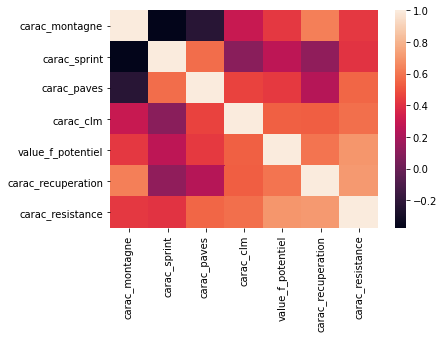

In [24]:
sns.heatmap(matrice_seg.corr());

#### 4.2 / ACP permettant la visualisation des corrélations et la réduction du nombre de dimensions

In [25]:
# Seuil que l'on peut faire varier
seuil = 0.75

# On initialise le classifieur PCA avec le nombre de variance que l'on souhaite garder 
#(ou comme ici, le % de variance à expliquer)
pca = PCA(n_components = seuil, whiten = True, random_state=2016)

# On fait une ACP sur nos données
pca.fit(matrice_seg)

# On regarde combien de composantes sont nécessaires pour expliquer au minimum 75% de la variance, 
# et le pourcentage de variance expliquée par chaque variable 
pca.explained_variance_ratio_ # 2 composantes expliquent 99% de la variance des données

# On transforme nos données avec l'ACP
pca_result = pca.transform(matrice_seg)
print(pca_result.shape)

# On sauvegarde les résultats dans notre jeu de données initial
PCAvar = pd.DataFrame(pca_result, columns=['PCA1','PCA2'])
PCAvar.head()

(908, 2)


,PCA1,PCA2
0,-0.182577,-1.347771
1,1.888759,-0.489929
2,1.644013,-0.101618
3,1.963875,-0.217351
4,0.531529,0.944469


In [26]:
print (pca.explained_variance_)
print("\n")
print (pca.explained_variance_ratio_)
print("\n")
print (pca.explained_variance_ratio_.cumsum())

[76.98944861 68.80773218]


[0.41820478 0.3737619 ]


[0.41820478 0.79196668]


In [27]:
#Préparation des données pour affichage
dfpca = pd.DataFrame(data = pca.explained_variance_ratio_
             , columns = ['Variance Expliquée'])
dfpca.index.name = 'Composantes'
dfpca.reset_index(inplace=True)
dfpca['Composantes'] +=1

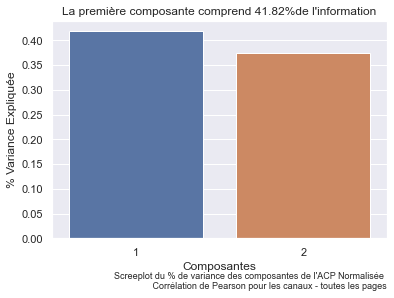

In [28]:
#Graphique Screeplot
sns.set()  #paramètres esthétiques ressemble à ggplot par défaut.
fig, ax = plt.subplots()  #un seul plot 
sns.barplot(x='Composantes', y= 'Variance Expliquée', data=dfpca )
ax.set(xlabel='Composantes', ylabel='% Variance Expliquée',
       title="La première composante comprend " + "{0:.2f}%".format(pca.explained_variance_ratio_[0]*100) + "de l'information")
fig.text(.9,-.05,"Screeplot du % de variance des composantes de l'ACP Normalisée \n Corrélation de Pearson pour les canaux - toutes les pages", fontsize=9, ha="right")
#plt.show()
fig.savefig("All-PCA-StandardScaler-Pearson-screeplot-channel.png", bbox_inches="tight", dpi=600)

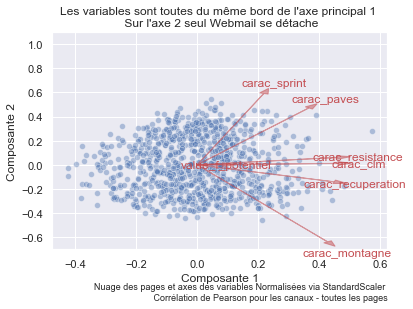

In [29]:
##############
##nuage des individus et axes des variables
labels=matrice_seg.columns.values
score= pca_result[:,0:2]
coeff=np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = score[:,0]
ys = score[:,1]  
#
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
#Graphique du nuage des pages et des axes des variables.
sns.set()  #paramètres esthétiques ressemble à ggplot par défaut.
fig, ax = plt.subplots()  #un seul plot 
sns.scatterplot(xs * scalex,ys * scaley, alpha=0.4) #
for i in range(n):
    ax.arrow(0, 0, coeff[i,0]*1, coeff[i,1]*1,color = 'r',alpha = 0.5, head_width=.03)
    ax.text(coeff[i,0]*1.15, coeff[i,1]*1.15 , labels[i], color = 'r', ha = 'center', va = 'center')
ax.set(xlabel='Composante 1', ylabel='Composante 2',
       title="Les variables sont toutes du même bord de l'axe principal 1 \n Sur l'axe 2 seul Webmail se détache")
ax.set_ylim((-0.7, 1.1))
fig.text(.9,-.05,"Nuage des pages et axes des variables Normalisées via StandardScaler \n Corrélation de Pearson pour les canaux - toutes les pages", fontsize=9, ha="right")
#plt.show()
fig.savefig("All-PCA-StandardScaler-Pearson-cloud-channel.png", bbox_inches="tight", dpi=600)

### 4.3/ CAH

Ajout des coordonnées ACP aux tables inputs.

In [30]:
#matrice_seg = pd.concat([matrice_seg,PCAvar],axis=1)
#matrice_seg.head()

In [31]:
#matrice_seg_N = pd.concat([matrice_seg_N,PCAvar],axis=1)
#matrice_seg_N.head()

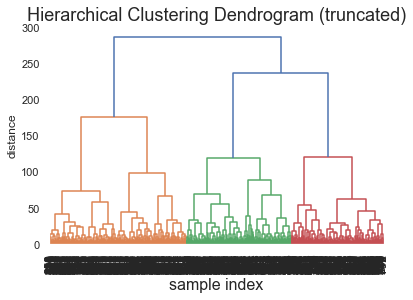

In [32]:
#générer la matrice des liens
Z = linkage(matrice_seg,method='ward',metric='euclidean')

plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize=18)
plt.xlabel('sample index', fontsize=16)
plt.ylabel('distance', fontsize=12)

dendrogram(Z, p=16, truncate_mode = 'level', leaf_font_size=12, leaf_rotation=90.)
plt.show()

In [33]:
hac = AgglomerativeClustering(n_clusters = 12, affinity = 'euclidean', linkage = 'ward')

hac.fit(matrice_seg)

pd.DataFrame(hac.labels_, columns = ['Cluster'])

,Cluster
0,0
1,7
2,7
3,4
4,8
...,...
903,11
904,5
905,11
906,11


On joint l'indicateur "Segment" à la base cyclistes.

In [34]:
cluster = pd.concat([cyclists_seg, pd.DataFrame(hac.labels_, columns = ['HAC'])], axis = 1)
print(cluster.columns)
cluster.head()

Index(['index', 'IDcyclist', 'Nom', 'Prenom', 'ID_team', 'value_f_potentiel',
       'carac_moy', 'carac_plaine', 'carac_montagne', 'carac_descente',
       'carac_paves', 'carac_clm', 'carac_prologue', 'carac_sprint',
       'carac_acceleration', 'carac_endurance', 'carac_resistance',
       'carac_recuperation', 'carac_vallon', 'carac_baroudeur',
       'gene_i_nb_victory', 'gene_i_nb_tdf', 'gene_i_nb_giro', 'ID_division',
       'HAC'],
      dtype='object')


,index,IDcyclist,Nom,Prenom,ID_team,value_f_potentiel,carac_moy,carac_plaine,carac_montagne,carac_descente,...,carac_endurance,carac_resistance,carac_recuperation,carac_vallon,carac_baroudeur,gene_i_nb_victory,gene_i_nb_tdf,gene_i_nb_giro,ID_division,HAC
0,0,2,Zeits,Andrey,Astana Qazaqstan Team,3.5,66.38,69,73,66,...,66,66,71,73,72,1,2,9,GS1,0
1,1,3,Valverde,Alejandro,Movistar Team,5.5,73.08,70,77,75,...,75,76,73,81,70,130,14,1,GS1,7
2,2,4,Madouas,Valentin,Groupama - FDJ,5.5,72.38,74,75,74,...,75,77,70,78,73,2,2,1,GS1,7
3,4,16,Mollema,Bauke,Trek - Segafredo,5.5,73.69,73,75,67,...,77,74,73,78,79,17,11,4,GS1,4
4,5,17,Van Emden,Jos,Team Jumbo - Visma,4.0,69.15,76,58,70,...,67,69,69,68,69,13,2,10,GS1,8


### 5 / Caractéristiques techniques de chaque segment

In [35]:
clust1=cluster.groupby("HAC")["carac_montagne"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust=clust1.iloc[:,0:2]
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'montagne'})
clust

,HAC,count,montagne
0,0,158,72.531646
1,1,102,62.980392
2,2,83,68.072289
3,3,103,66.038835
4,4,93,75.989247
5,5,60,58.950000
6,6,98,58.010204
7,7,27,69.888889
8,8,49,63.102041
9,9,54,59.259259


In [36]:
clust1=cluster.groupby("HAC")["carac_sprint"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'sprint'})
clust

,HAC,count,montagne,sprint
0,0,158,72.531646,62.278481
1,1,102,62.980392,69.990196
2,2,83,68.072289,57.698795
3,3,103,66.038835,61.281553
4,4,93,75.989247,62.526882
5,5,60,58.950000,62.650000
6,6,98,58.010204,70.908163
7,7,27,69.888889,69.740741
8,8,49,63.102041,60.734694
9,9,54,59.259259,76.314815


In [37]:
clust1=cluster.groupby("HAC")["carac_paves"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'paves'})
clust

,HAC,count,montagne,sprint,paves
0,0,158,72.531646,62.278481,61.987342
1,1,102,62.980392,69.990196,72.617647
2,2,83,68.072289,57.698795,57.048193
3,3,103,66.038835,61.281553,61.359223
4,4,93,75.989247,62.526882,65.666667
5,5,60,58.950000,62.650000,66.016667
6,6,98,58.010204,70.908163,66.142857
7,7,27,69.888889,69.740741,76.037037
8,8,49,63.102041,60.734694,69.040816
9,9,54,59.259259,76.314815,70.944444


In [38]:
clust1=cluster.groupby("HAC")["carac_resistance"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'resistance'})
clust

,HAC,count,montagne,sprint,paves,resistance
0,0,158,72.531646,62.278481,61.987342,67.715190
1,1,102,62.980392,69.990196,72.617647,68.960784
2,2,83,68.072289,57.698795,57.048193,61.433735
3,3,103,66.038835,61.281553,61.359223,63.563107
4,4,93,75.989247,62.526882,65.666667,70.698925
5,5,60,58.950000,62.650000,66.016667,63.083333
6,6,98,58.010204,70.908163,66.142857,65.071429
7,7,27,69.888889,69.740741,76.037037,75.814815
8,8,49,63.102041,60.734694,69.040816,66.510204
9,9,54,59.259259,76.314815,70.944444,68.777778


In [39]:
clust1=cluster.groupby("HAC")["carac_clm"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'clm'})
clust

,HAC,count,montagne,sprint,paves,resistance,clm
0,0,158,72.531646,62.278481,61.987342,67.715190,64.537975
1,1,102,62.980392,69.990196,72.617647,68.960784,66.950980
2,2,83,68.072289,57.698795,57.048193,61.433735,58.759036
3,3,103,66.038835,61.281553,61.359223,63.563107,62.466019
4,4,93,75.989247,62.526882,65.666667,70.698925,72.978495
5,5,60,58.950000,62.650000,66.016667,63.083333,63.850000
6,6,98,58.010204,70.908163,66.142857,65.071429,62.071429
7,7,27,69.888889,69.740741,76.037037,75.814815,73.592593
8,8,49,63.102041,60.734694,69.040816,66.510204,70.346939
9,9,54,59.259259,76.314815,70.944444,68.777778,63.259259


In [40]:
clust1=cluster.groupby("HAC")["carac_recuperation"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'recuperation'})
clust

,HAC,count,montagne,sprint,paves,resistance,clm,recuperation
0,0,158,72.531646,62.278481,61.987342,67.715190,64.537975,69.917722
1,1,102,62.980392,69.990196,72.617647,68.960784,66.950980,68.225490
2,2,83,68.072289,57.698795,57.048193,61.433735,58.759036,63.313253
3,3,103,66.038835,61.281553,61.359223,63.563107,62.466019,65.757282
4,4,93,75.989247,62.526882,65.666667,70.698925,72.978495,74.290323
5,5,60,58.950000,62.650000,66.016667,63.083333,63.850000,62.950000
6,6,98,58.010204,70.908163,66.142857,65.071429,62.071429,64.489796
7,7,27,69.888889,69.740741,76.037037,75.814815,73.592593,71.518519
8,8,49,63.102041,60.734694,69.040816,66.510204,70.346939,68.020408
9,9,54,59.259259,76.314815,70.944444,68.777778,63.259259,68.222222


In [41]:
clust1=cluster.groupby("HAC")["carac_moy"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'carac_moy'})
clust

,HAC,count,montagne,sprint,paves,resistance,clm,recuperation,carac_moy
0,0,158,72.531646,62.278481,61.987342,67.715190,64.537975,69.917722,67.957975
1,1,102,62.980392,69.990196,72.617647,68.960784,66.950980,68.225490,69.696569
2,2,83,68.072289,57.698795,57.048193,61.433735,58.759036,63.313253,62.615301
3,3,103,66.038835,61.281553,61.359223,63.563107,62.466019,65.757282,64.881845
4,4,93,75.989247,62.526882,65.666667,70.698925,72.978495,74.290323,71.254516
5,5,60,58.950000,62.650000,66.016667,63.083333,63.850000,62.950000,64.575667
6,6,98,58.010204,70.908163,66.142857,65.071429,62.071429,64.489796,65.940918
7,7,27,69.888889,69.740741,76.037037,75.814815,73.592593,71.518519,74.002963
8,8,49,63.102041,60.734694,69.040816,66.510204,70.346939,68.020408,67.625102
9,9,54,59.259259,76.314815,70.944444,68.777778,63.259259,68.222222,68.940741


In [42]:
clust1=cluster.groupby("HAC")["value_f_potentiel"].agg([pd.Series.count,pd.Series.max,pd.Series.min,pd.Series.mean]).reset_index()
clust1=clust1.iloc[:,4:]
clust= pd.concat([clust,clust1],axis=1)
clust=clust.rename(columns={'mean': 'potentiel'})
clust

,HAC,count,montagne,sprint,paves,resistance,clm,recuperation,carac_moy,potentiel
0,0,158,72.531646,62.278481,61.987342,67.715190,64.537975,69.917722,67.957975,4.044304
1,1,102,62.980392,69.990196,72.617647,68.960784,66.950980,68.225490,69.696569,4.186275
2,2,83,68.072289,57.698795,57.048193,61.433735,58.759036,63.313253,62.615301,3.126506
3,3,103,66.038835,61.281553,61.359223,63.563107,62.466019,65.757282,64.881845,3.281553
4,4,93,75.989247,62.526882,65.666667,70.698925,72.978495,74.290323,71.254516,4.903226
5,5,60,58.950000,62.650000,66.016667,63.083333,63.850000,62.950000,64.575667,3.116667
6,6,98,58.010204,70.908163,66.142857,65.071429,62.071429,64.489796,65.940918,3.454082
7,7,27,69.888889,69.740741,76.037037,75.814815,73.592593,71.518519,74.002963,5.166667
8,8,49,63.102041,60.734694,69.040816,66.510204,70.346939,68.020408,67.625102,3.897959
9,9,54,59.259259,76.314815,70.944444,68.777778,63.259259,68.222222,68.940741,4.435185


#### Echantillon de 3 coureurs par segment.

In [50]:
a=cluster[cluster['HAC'] == 0].sort_values(by=["carac_montagne"],ascending=False).reset_index().iloc[:3,:]
b=cluster[cluster['HAC'] == 1].sort_values(by=["carac_sprint"],ascending=False).reset_index().iloc[:3,:]

c=cluster[cluster['HAC'] == 2].sort_values(by=["carac_moy"],ascending=False).reset_index().iloc[:3,:]
d=cluster[cluster['HAC'] == 3].sort_values(by=["carac_montagne"],ascending=False).reset_index().iloc[:3,:]

e=cluster[cluster['HAC'] == 4].sort_values(by=["carac_montagne"],ascending=False).reset_index().iloc[:3,:]
f=cluster[cluster['HAC'] == 5].sort_values(by=["carac_paves"],ascending=False).reset_index().iloc[:3,:]

g=cluster[cluster['HAC'] == 6].sort_values(by=["carac_sprint"],ascending=False).reset_index().iloc[:3,:]
h=cluster[cluster['HAC'] == 7].sort_values(by=["carac_paves"],ascending=False).reset_index().iloc[:3,:]

i=cluster[cluster['HAC'] == 8].sort_values(by=["carac_clm"],ascending=False).reset_index().iloc[:3,:]
j=cluster[cluster['HAC'] == 9].sort_values(by=["carac_sprint"],ascending=False).reset_index().iloc[:3,:]

k=cluster[cluster['HAC'] == 10].sort_values(by=["carac_moy"],ascending=False).reset_index().iloc[:3,:]
l=cluster[cluster['HAC'] == 11].sort_values(by=["carac_moy"],ascending=False).reset_index().iloc[:3,:]

 
m=pd.concat([a,b,c,d,e,f,g,h,i,j,k,l],axis=0)

m

,level_0,index,IDcyclist,Nom,Prenom,ID_team,value_f_potentiel,carac_moy,carac_plaine,carac_montagne,...,carac_endurance,carac_resistance,carac_recuperation,carac_vallon,carac_baroudeur,gene_i_nb_victory,gene_i_nb_tdf,gene_i_nb_giro,ID_division,HAC
0,151,185,2543,Bardet,Romain,Team DSM,5.5,73.46,71,80,...,78,74,76,78,72,9,8,1,GS1,0
1,241,332,3357,Woods,Michael,Israël - Premier Tech,5.0,70.15,69,79,...,73,75,71,81,69,8,2,2,GS1,0
2,102,123,2074,Chaves,Esteban,EF Education-EasyPost,5.0,70.54,69,79,...,77,72,69,78,75,16,3,4,GS1,0
0,79,96,1947,Sagan,Peter,Team TotalEnergies,5.5,74.15,73,65,...,72,72,74,71,80,119,10,2,GS2,1
1,724,1435,7110,Girmay,Biniam,Intermarché-Wanty-Gobert Matériaux,5.5,72.00,76,65,...,72,74,71,76,71,5,0,0,GS1,1
2,148,182,2537,Colbrelli,Sonny,Bahrain Victorious,5.0,72.77,77,70,...,73,74,71,76,65,34,5,5,GS1,1
0,710,1414,7087,Buitrago,Santiago,Bahrain Victorious,4.0,67.23,68,76,...,69,69,66,75,70,0,0,0,GS1,2
1,149,183,2541,Elissonde,Kenny,Trek - Segafredo,4.0,67.00,66,75,...,67,66,71,73,74,2,2,3,GS1,2
2,696,1394,7064,Rubio,Einer,Movistar Team,5.0,66.69,65,76,...,70,67,70,74,72,0,0,2,GS1,2
0,774,1692,7383,Vandenabeele,Henri,Team DSM,5.0,65.38,68,72,...,66,65,65,73,61,0,0,0,GS1,3


### 6 / Export

In [48]:
# Export du livrable.
cluster.to_excel(results + "/" + str(DTJ)  + "_Seg_cyclists" + ".xlsx",sheet_name="base")
#clust.to_excel(results + "/" + str(DTJ)  + "_Seg_cyclists" + ".xlsx",sheet_name="stats")

<ipython-input-48-a20db97c8c8a>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  cluster.to_excel(results + "/" + str(DTJ)  + "_Seg_cyclists" + ".xlsx",sheet_name="base")
